In [18]:
import requests
from scraper.headers import HEADERS

In [11]:
import json
from pathlib import Path

In [1]:
import pandas as pd
import numpy as np

In [4]:
RESULTS_DIR = Path("__file__").parent / "data" / "results"
assert RESULTS_DIR.exists()

In [20]:
response = requests.get("https://2022electionresults.comelec.gov.ph/data/contests/5587.json", headers=HEADERS)
data_map_president = pd.DataFrame(response.json()["bos"])

In [24]:
data_map_president["bo"] = data_map_president["boc"]
data_map_president

,boc,bon,boi,to,pc,pn,pcc,pcy,pcm,pck,bo
0,46446,"PACQUIAO, MANNY PACMAN(PROMDI)",46438.png,9,279,ABAG PROMDI,1,1,1,1,46446
1,46440,"DOMAGOSO, ISKO MORENO (AKSYON)",46441.png,3,281,AKSYON DEMOKRATIKO,1,1,1,1,46440
2,46445,"MONTEMAYOR, JOSE JR. (DPP)",46439.png,8,288,DEMOCRATIC PARTY OF THE PHILIPPINES,1,1,1,1,46445
3,46443,"MANGONDATO, FAISAL (KTPNAN)",46440.png,6,290,KATIPUNAN NG KAMALAYANG KAYUMANGGI,1,1,1,1,46443
4,46441,"GONZALES, NORBERTO (PDSP)",46444.png,4,299,PARTIDO DEMOKRATIKO SOSYALISTA NG PILIPINAS,1,1,1,1,46441
5,46439,"DE GUZMAN, LEODY (PLM)",46445.png,2,300,PARTIDO LAKAS NG MASA,1,1,1,1,46439
6,46442,"LACSON, PING (PDR)",46443.png,5,301,PARTIDO PARA SA DEMOKRATIKONG REPORMA,1,1,1,1,46442
7,46438,"ABELLA, ERNIE (IND)",46447.png,1,343,INDEPENDENT,1,1,1,1,46438
8,46447,"ROBREDO, LENI (IND)",46446.png,10,343,INDEPENDENT,1,1,1,1,46447
9,46444,"MARCOS, BONGBONG (PFP)",46442.png,7,345,PARTIDO FEDERAL NG PILIPINAS,1,1,1,1,46444


In [57]:
results_files = list(RESULTS_DIR.glob("*/*.json"))
len(results_files)

2398

In [58]:
p = 0.5
rvs = np.random.geometric(0.5, size=len(results_files))
pd.Series(rvs).describe()

count    2398.000000
mean        2.024187
std         1.420776
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        13.000000
dtype: float64

In [59]:
fields = ["bo", "v", "tot", "per", "ser", "bon", "pc", "pn"]

batch = {rv: [] for rv in rvs}

for rv, rf in zip(rvs, results_files):
    d = json.loads(rf.read_text())
    d = pd.DataFrame(d["rs"])
    pres = d[d["cc"] == 5587]
    pres = pres.merge(data_map_president, on="bo", how="left")

    batch[rv].append(pres[fields])

In [60]:
rv_data = []

for rv in sorted(batch.keys()):
    b = pd.concat(batch[rv])
    b = b.groupby("bon")["v"].sum()

    db = dict(
        count=len(batch[rv]),
        hour=rv,
        total=b.sum()
    )
    db.update(b.to_dict())
    rv_data.append(db)

rv_data = pd.DataFrame(rv_data).set_index(["hour", "count"])
rv_data

,,total,"ABELLA, ERNIE (IND)","DE GUZMAN, LEODY (PLM)","DOMAGOSO, ISKO MORENO (AKSYON)","GONZALES, NORBERTO (PDSP)","LACSON, PING (PDR)","MANGONDATO, FAISAL (KTPNAN)","MARCOS, BONGBONG (PFP)","MONTEMAYOR, JOSE JR. (DPP)","PACQUIAO, MANNY PACMAN(PROMDI)","ROBREDO, LENI (IND)"
hour,count,,,,,,,,,,,
1,1160,513164,509,390,2231,266,2676,294,485875,256,1935,18732
2,609,268666,218,194,1126,169,1427,163,254158,122,1008,10081
3,352,152267,130,108,663,80,793,158,144088,86,566,5595
4,123,53441,44,42,260,36,289,18,50488,28,234,2002
5,77,34486,27,23,144,29,182,6,32642,24,139,1270
6,39,16935,9,10,59,15,87,3,16041,1,85,625
7,16,6567,6,5,48,12,43,2,6157,1,37,256
8,13,5642,6,7,14,2,25,0,5378,2,16,192
9,5,2921,2,4,17,3,24,0,2640,1,24,206


In [63]:
rv_data.divide(rv_data["total"], axis=0)

,,total,"ABELLA, ERNIE (IND)","DE GUZMAN, LEODY (PLM)","DOMAGOSO, ISKO MORENO (AKSYON)","GONZALES, NORBERTO (PDSP)","LACSON, PING (PDR)","MANGONDATO, FAISAL (KTPNAN)","MARCOS, BONGBONG (PFP)","MONTEMAYOR, JOSE JR. (DPP)","PACQUIAO, MANNY PACMAN(PROMDI)","ROBREDO, LENI (IND)"
hour,count,,,,,,,,,,,
1,1160,1.0,0.000992,0.000760,0.004348,0.000518,0.005215,0.000573,0.946822,0.000499,0.003771,0.036503
2,609,1.0,0.000811,0.000722,0.004191,0.000629,0.005311,0.000607,0.946000,0.000454,0.003752,0.037522
3,352,1.0,0.000854,0.000709,0.004354,0.000525,0.005208,0.001038,0.946285,0.000565,0.003717,0.036745
4,123,1.0,0.000823,0.000786,0.004865,0.000674,0.005408,0.000337,0.944743,0.000524,0.004379,0.037462
5,77,1.0,0.000783,0.000667,0.004176,0.000841,0.005278,0.000174,0.946529,0.000696,0.004031,0.036827
6,39,1.0,0.000531,0.000590,0.003484,0.000886,0.005137,0.000177,0.947210,0.000059,0.005019,0.036906
7,16,1.0,0.000914,0.000761,0.007309,0.001827,0.006548,0.000305,0.937567,0.000152,0.005634,0.038983
8,13,1.0,0.001063,0.001241,0.002481,0.000354,0.004431,0.000000,0.953208,0.000354,0.002836,0.034030
9,5,1.0,0.000685,0.001369,0.005820,0.001027,0.008216,0.000000,0.903800,0.000342,0.008216,0.070524


<AxesSubplot:xlabel='hour,count'>

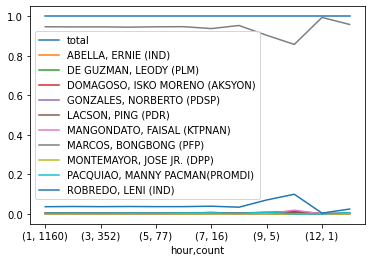

In [64]:
rv_data.divide(rv_data["total"], axis=0).plot()

In [56]:
rv_data.divide(rv_data["total"], axis=0)

,,total,"ABELLA, ERNIE (IND)","DE GUZMAN, LEODY (PLM)","DOMAGOSO, ISKO MORENO (AKSYON)","GONZALES, NORBERTO (PDSP)","LACSON, PING (PDR)","MANGONDATO, FAISAL (KTPNAN)","MARCOS, BONGBONG (PFP)","MONTEMAYOR, JOSE JR. (DPP)","PACQUIAO, MANNY PACMAN(PROMDI)","ROBREDO, LENI (IND)"
hour,count,,,,,,,,,,,
1,792,1.0,0.000729,0.000520,0.003735,0.000458,0.004616,0.000681,0.954193,0.000503,0.002632,0.031933
2,408,1.0,0.000732,0.000475,0.003681,0.000520,0.004447,0.000709,0.956420,0.000380,0.002816,0.029820
3,213,1.0,0.000963,0.000504,0.003995,0.000558,0.004565,0.000361,0.953938,0.000504,0.003087,0.031525
4,101,1.0,0.001046,0.000409,0.003593,0.000750,0.003956,0.000728,0.956935,0.000387,0.003433,0.028763
5,64,1.0,0.000887,0.000639,0.002591,0.000461,0.003940,0.000319,0.957580,0.000568,0.003798,0.029214
6,28,1.0,0.000806,0.000484,0.003627,0.000403,0.004674,0.001209,0.951483,0.000322,0.004191,0.032801
7,11,1.0,0.000880,0.000440,0.003298,0.000880,0.005717,0.000000,0.958223,0.000440,0.001539,0.028584
8,8,1.0,0.001302,0.000000,0.002083,0.001563,0.006250,0.000260,0.943229,0.000000,0.003906,0.041406
9,5,1.0,0.001369,0.000456,0.009585,0.000913,0.006846,0.004564,0.916020,0.000000,0.002282,0.057964
